<a href="https://colab.research.google.com/github/Bani-Talebi/Electricity-Price-Forecasting/blob/master/Quantile_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm

from scipy.stats import norm

from sklearn import ensemble

import tensorflow as tf
from tensorflow import keras
from google.colab import files

In [ ]:
up=files.upload()

Saving PF_Input.csv to PF_Input.csv


In [ ]:
DF=pd.read_csv('PF_Input.csv',index_col=0,parse_dates=True)

train_labels=DF['2015':'2018']['HOEP'].values
test_labels=DF['2019']['HOEP'].values

DF.drop(columns=['HOEP'],inplace=True)

train_data=DF['2015':'2018'].values
test_data=DF['2019'].values

#Keras and Tensorflow Settings
EPOCHS = 200
BATCH_SIZE = 64
UNITS = 128
sns.set_style('white')
#DPI = 200
#mpl.rc('savefig', dpi=DPI)
#mpl.rcParams['figure.dpi'] = DPI
mpl.rcParams['figure.figsize'] = 3.5, 2.8  # Default.
mpl.rcParams['font.sans-serif'] = 'STIXGeneral'
mpl.rcParams['font.family'] = 'STIXGeneral'

# Set title text color to dark gray (https://material.io/color) not black.
#TITLE_COLOR = '#212121'
#mpl.rcParams['text.color'] = TITLE_COLOR

# Axis titles and tick marks are medium gray.
#AXIS_COLOR = '#757575'
#mpl.rcParams['axes.labelcolor'] = AXIS_COLOR
#mpl.rcParams['xtick.color'] = AXIS_COLOR
#mpl.rcParams['ytick.color'] = AXIS_COLOR
#Make DataFrames
column_names = DF.columns

train_df = pd.DataFrame(train_data, columns=column_names)
test_df = pd.DataFrame(test_data, columns=column_names)
#Normalize
mean = train_df.mean(axis=0)
std = train_df.std(axis=0)
train_df = (train_df - mean) / std
test_df = (test_df - mean) / std

x_train = train_df.XGB
x_test = test_df.XGB

#Denormalize
def denorm_XGB(x):
    return x * std.XGB + mean.XGB

x_train_denorm = denorm_XGB(x_train)
x_test_denorm = denorm_XGB(x_test)

#Reformat data for statsmodels.
X_train = sm.add_constant(x_train)
X_test = sm.add_constant(x_test)
x_train_expanded = np.expand_dims(x_train, 1)
x_test_expanded = np.expand_dims(x_test, 1)
train_labels_expanded = np.expand_dims(train_labels, 1)

#Initialize result
#Dataset per method, quantile, and x value.
#####METHODS = ['Quantile Regression', 'Gradient Boosting', 'Neural Network']

METHODS = ['QRA', 'GBR', 'NN']
QUANTILES = [0.05,0.10,0.15,0.20,0.25,0.30, 0.35,0.40,0.45,0.50, 0.55,0.60,0.65, 0.70,0.75,0.80,0.85, 0.90,0.95]
# QUANTILES.reverse()  # Test out to see if we're getting different results.

quantiles_legend = [str(int(q * 100)) + 'th percentile' for q in QUANTILES]

sns.set_palette(sns.color_palette('Blues', len(QUANTILES)))
sns.set_palette(sns.color_palette('Blues'))
# Set dots to a light gray
#dot_color = sns.color_palette('coolwarm', 3)[1]

preds = np.array([(method, q, x) 
                  for method in METHODS 
                  for q in QUANTILES
                  for x in x_test])
preds = pd.DataFrame(preds)
preds.columns = ['method', 'q', 'x']
preds = preds.apply(lambda x: pd.to_numeric(x, errors='ignore'))

preds['label'] = np.resize(test_labels, preds.shape[0])

#Quantile loss example
# pandas version rather than Keras.
def quantile_loss(q, y, f):
    # q: Quantile to be evaluated, e.g., 0.5 for median.
    # y: True value.
    # f: Fitted or predicted value.
    e = y - f
    return np.maximum(q * e, (q - 1) * e)

#QuantReg
quantreg = sm.QuantReg(train_labels, X_train)  # Don't fit yet, since we'll fit once per quantile.
preds.loc[preds.method == 'QRA', 'pred'] = np.concatenate([quantreg.fit(q=q).predict(X_test) for q in QUANTILES]) 

np.random.seed(7)
tf.random.set_seed(7)


0.05
0.1
0.15
0.2
0.25
0.3
0.35
0.4
0.45
0.5
0.55
0.6
0.65
0.7
0.75
0.8
0.85
0.9
0.95
        quantile_loss
method               
GBR          2.788502
QRA          2.798774
NN           2.807859
method       GBR       QRA        NN
q                                   
0.05    0.710152  0.721191  0.705290
0.10    1.251452  1.246175  1.235085
0.15    1.703632  1.694512  1.693053
0.20    2.104663  2.087954  2.092043
0.25    2.452907  2.431324  2.457256
0.30    2.753438  2.729011  2.770924
0.35    3.018262  2.983296  3.020794
0.40    3.223029  3.199538  3.234750
0.45    3.396557  3.375314  3.420363
0.50    3.526594  3.508585  3.562258
0.55    3.604822  3.601498  3.662465
0.60    3.642456  3.653383  3.701840
0.65    3.629274  3.662741  3.684965
0.70    3.574115  3.619570  3.608296
0.75    3.456613  3.515079  3.474184
0.80    3.275091  3.341513  3.304398
0.85    3.010204  3.074686  2.999706
0.90    2.617991  2.676998  2.644680
0.95    2.030280  2.054330  2.076980


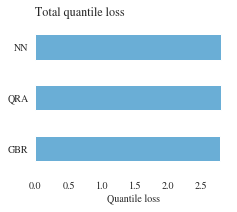

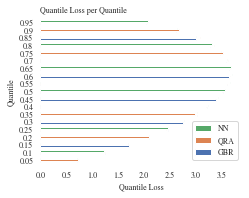

In [ ]:
#Gradient boosted trees
def gb_quantile(X_train, train_labels, X, q):
    gbf = ensemble.GradientBoostingRegressor(loss='quantile', alpha=q,
                                             n_estimators=150,
                                             max_depth=5,
                                             learning_rate=0.045, min_samples_leaf=9,
                                             min_samples_split=9)
    gbf.fit(X_train, train_labels)
    return gbf.predict(X)
preds.loc[preds.method == 'GBR', 'pred'] = np.concatenate(
    [gb_quantile(X_train, train_labels, X_test, q) for q in QUANTILES]) 


def tilted_loss(q, y, f):
    e = (y - f)
    return keras.backend.mean(keras.backend.maximum(q * e, (q - 1) * e), axis=-1)
#optimizer = tf.train.AdamOptimizer(0.001)
#early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10)
mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', save_best_only=True, save_weights_only=True)
tb = TensorBoard('logs')

def keras_pred(x_train, train_labels, x_test, q):
    print(q)
    # Set input_dim for the number of features.
    if len(x_train.shape) == 1:
        input_dim = 1
    else:
        input_dim = x_train.shape[1]
    model = keras.Sequential([
      keras.layers.Dense(UNITS, activation=tf.nn.relu,
                         input_dim=input_dim),
      keras.layers.Dense(UNITS, activation=tf.nn.relu),
      keras.layers.Dense(1)
    ])
    
    model.compile(loss=lambda y, f: tilted_loss(q, y, f), optimizer='adam')
    model.fit(x_train, train_labels, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0, validation_split=0.2, callbacks=[es, rlr, mcp, tb])
    
    # Predict the quantile
    return model.predict(x_test)
preds.loc[preds.method == 'NN', 'pred'] = np.concatenate(
    [keras_pred(x_train_expanded, train_labels, x_test_expanded, q) 
     for q in QUANTILES]) 
preds['x_denorm'] = denorm_XGB(preds.x)

#Compare quantile loss
preds['quantile_loss'] = quantile_loss(preds.q, preds.label, preds.pred)
def plot_loss_comparison(preds):
    overall_loss_comparison = preds[~preds.quantile_loss.isnull()].\
      pivot_table(index='method', values='quantile_loss').\
      sort_values('quantile_loss')
    # Show overall table.
    print(overall_loss_comparison)
    
    


  
    # Plot overall.
    with sns.color_palette('Blues', 1):
        ax = overall_loss_comparison.plot.barh()
        plt.title('Total quantile loss', loc='left')
        sns.despine(left=True, bottom=True)
        plt.xlabel('Quantile loss')
        plt.ylabel('')
        ax.legend_.remove()
        #plt.savefig('Total Quantile Loss..pdf',dpi=300)
        #files.download('Total Quantile Loss.pdf')
  
    # Per quantile.
    per_quantile_loss_comparison = preds[~preds.quantile_loss.isnull()].\
        pivot_table(index='q', columns='method', values='quantile_loss')
    # Sort by overall quantile loss.
    per_quantile_loss_comparison = \
        per_quantile_loss_comparison[overall_loss_comparison.index]
    print(per_quantile_loss_comparison)
  
    # Plot per quantile.
    with sns.color_palette('deep'):
        plt.rcParams['font.size']=8
        plt.rcParams['figure.autolayout']=True
        plt.rcParams['axes.titlesize']=8
        plt.rcParams['axes.labelsize']=8
        plt.rcParams['lines.linewidth']=1
        plt.rcParams['lines.markersize']=2
        plt.rcParams['legend.fontsize']=8
        plt.rcParams['mathtext.fontset']='stix'
        plt.rcParams['mathtext.fontset']='custom'
        plt.rcParams['legend.numpoints']=1

        ax = per_quantile_loss_comparison.plot.barh()
        plt.title('Quantile Loss per Quantile', loc='left')
        sns.despine(left=True, bottom=True)
        handles, labels = ax.get_legend_handles_labels()
        plt.xlabel('Quantile Loss')
        plt.ylabel('Quantile')
        # Reverse legend.
        ax.legend(reversed(handles), reversed(labels))
        #plt.savefig('Per Quantile Loss.png',dpi=300)
        #files.download('Per Quantile Loss.png')
plot_loss_comparison(preds)




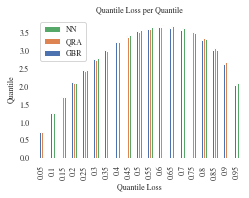

In [ ]:
#sns.set_style('dark')
def plot_loss_comparison(preds):
    overall_loss_comparison = preds[~preds.quantile_loss.isnull()].\
      pivot_table(index='method', values='quantile_loss').\
      sort_values('quantile_loss')
    # Show overall table.
    #print(overall_loss_comparison)
    
    


  

  
    # Per quantile.
    per_quantile_loss_comparison = preds[~preds.quantile_loss.isnull()].\
        pivot_table(index='q', columns='method', values='quantile_loss')
    # Sort by overall quantile loss.
    per_quantile_loss_comparison = \
        per_quantile_loss_comparison[overall_loss_comparison.index]
  
    # Plot per quantile.
    with sns.color_palette('deep'):
        plt.rcParams['font.family']='STIXGeneral'
        plt.rcParams['font.size']=8
        plt.rcParams['figure.autolayout']=True
        plt.rcParams['axes.titlesize']=8
        plt.rcParams['axes.labelsize']=8
        plt.rcParams['lines.linewidth']=1
        plt.rcParams['lines.markersize']=2
        plt.rcParams['legend.fontsize']=8
        plt.rcParams['mathtext.fontset']='stix'
        plt.rcParams['mathtext.fontset']='custom'
        plt.rcParams['legend.numpoints']=1

        ax = per_quantile_loss_comparison.plot.bar()
        plt.title('Quantile Loss per Quantile')
        sns.despine(left=True, bottom=True)
        handles, labels = ax.get_legend_handles_labels()
        plt.xlabel('Quantile Loss')
        plt.ylabel('Quantile')
        # Reverse legend.
        ax.legend(reversed(handles), reversed(labels))
        #plt.savefig('Per Quantile Loss.png',dpi=300)
        #files.download('Per Quantile Loss.png')
plot_loss_comparison(preds)

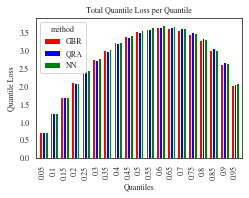

In [ ]:

overall_loss_comparison = preds[~preds.quantile_loss.isnull()].\
  pivot_table(index='method', values='quantile_loss').\
  sort_values('quantile_loss')
# Show overall table.

# Per quantile.
per_quantile_loss_comparison = preds[~preds.quantile_loss.isnull()].\
    pivot_table(index='q', columns='method', values='quantile_loss')
# Sort by overall quantile loss.
per_quantile_loss_comparison = \
    per_quantile_loss_comparison[overall_loss_comparison.index]


per_quantile_loss_comparison.plot.bar(color={'GBR':'red', 'QRA':'blue', 'NN':'green'},figsize=(3.5,2.8),width=0.8)
plt.ylabel('Quantile Loss')
plt.xlabel('Quantiles')
plt.title('Total Quantile Loss per Quantile')
#plt.savefig('Per Quantile Loss.pdf',dpi=300)
#files.download('Per Quantile Loss.pdf')
plt.rcParams['font.size']=8
plt.rcParams['figure.autolayout']=True
plt.rcParams['axes.titlesize']=8
plt.rcParams['axes.labelsize']=8
plt.rcParams['lines.linewidth']=1
plt.rcParams['lines.markersize']=2
plt.rcParams['legend.fontsize']=8
plt.rcParams['mathtext.fontset']='stix'
plt.rcParams['mathtext.fontset']='custom'
plt.rcParams['legend.numpoints']=1

In [ ]:
L=8760
QR=pd.DataFrame(preds['label'].iloc[0:L])
QR.index=DF['2019'].index
i=0
for q in QUANTILES:
  QR['q={}'.format(q)]=preds['pred'].iloc[i*L:(i+1)*L].values
  i+=1
GB=pd.DataFrame(preds['label'].iloc[0:L])
GB.index=DF['2019'].index
for q in QUANTILES:
  GB['q={}'.format(q)]=preds['pred'].iloc[i*L:(i+1)*L].values
  i+=1
NN=pd.DataFrame(preds['label'].iloc[0:L])
NN.index=DF['2019'].index
for q in QUANTILES:
  NN['q={}'.format(q)]=preds['pred'].iloc[i*L:(i+1)*L].values
  i+=1


In [ ]:
GB.to_csv('Quantiles.csv')
files.download('Quantiles.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Reliability**

In [ ]:
QR_Calibration=np.zeros(len(QUANTILES))
col=QR.columns
a=QR[col[0]].values
l=len(col)
for i in range(1,l):
  b=QR[col[i]].values
  QR_Calibration[i-1]=sum(b>a)/len(QR)

GB_Calibration=np.zeros(len(QUANTILES))
col=GB.columns
a=GB[col[0]].values
l=len(col)
for i in range(1,l):
  b=GB[col[i]].values
  GB_Calibration[i-1]=sum(b>a)/len(GB)

NN_Calibration=np.zeros(len(QUANTILES))
col=NN.columns
a=NN[col[0]].values
l=len(col)
for i in range(1,l):
  b=NN[col[i]].values
  NN_Calibration[i-1]=sum(b>a)/len(NN)

print('Reliability of QRA:',np.sqrt(sum((QR_Calibration-QUANTILES)**2)))
print('Reliability of GBA:',np.sqrt(sum((GB_Calibration-QUANTILES)**2)))
print('Reliability of NNA:',np.sqrt(sum((NN_Calibration-QUANTILES)**2)))

Reliability of QRA: 0.09084126015649108
Reliability of GBA: 0.044546444874115645
Reliability of NNA: 0.2348144657889681


Text(0.5, 1.0, 'Reliability Assessment of Quantile Forecasting Methods')

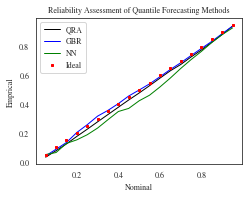

In [ ]:
plt.plot(QUANTILES,QR_Calibration,color='black',label='QRA')
plt.plot(QUANTILES,GB_Calibration,color='blue',label='GBR')
plt.plot(QUANTILES,NN_Calibration,color='green',label='NN')
plt.plot(QUANTILES,QUANTILES,'rs',label='Ideal')
plt.xlabel('Nominal')
plt.ylabel('Emprical')
plt.legend()
plt.title('Reliability Assessment of Quantile Forecasting Methods')
#plt.savefig('Reliability.png',dpi=300)
#files.download('Reliability.png')

# **Sharpness**

In [ ]:
I=np.array([90,80,70,60,50,40,30,20,10])
#QRA
col=QR.columns
l=len(col)
t=1
for i in I:
  QR['I={}'.format(i)]=QR[col[l-t]]-QR[col[t]]
  t+=1
col=QR.columns
l1=len(col)
l2=len(QUANTILES)+1
col=col[l2:l1]
#GB
col=GB.columns
l=len(col)
t=1
for i in I:
  GB['I={}'.format(i)]=GB[col[l-t]]-GB[col[t]]
  t+=1
col=GB.columns
l1=len(col)
l2=len(QUANTILES)+1
col=col[l2:l1]
#NN
col=NN.columns
l=len(col)
t=1
for i in I:
  NN['I={}'.format(i)]=NN[col[l-t]]-NN[col[t]]
  t+=1
col=NN.columns
l1=len(col)
l2=len(QUANTILES)+1
col=col[l2:l1]

a1=GB[col].mean()
a2=QR[col].mean()
a3=NN[col].mean()
print('Sharpness of QR:',a2.mean())
print('Sharpness of GB:',a1.mean())
print('Sharpness of NN:',a3.mean())


Sharpness of QR: 11.302789205152134
Sharpness of GB: 11.12306843763462
Sharpness of NN: 11.07384093431136


# **CRPS**

In [ ]:
GB.head()

,label,q=0.05,q=0.1,q=0.15,q=0.2,q=0.25,q=0.3,q=0.35,q=0.4,q=0.45,q=0.5,q=0.55,q=0.6,q=0.65,q=0.7,q=0.75,q=0.8,q=0.85,q=0.9,q=0.95,I=90,I=80,I=70,I=60,I=50,I=40,I=30,I=20,I=10
2019-01-01 00:00:00,0.00,-3.470430,-2.997247,-1.844386,-0.829184,-0.236499,0.005226,0.006488,0.009121,0.011794,0.117657,0.588252,1.305168,2.683097,3.465385,5.366748,5.867281,7.385476,9.914421,13.094358,16.564788,12.911667,9.229861,6.696465,5.603247,3.460159,2.676609,1.296047,0.576458
2019-01-01 01:00:00,0.00,-3.470430,-2.997247,-1.844386,-0.829184,-0.236499,0.005226,0.006488,0.009121,0.011794,0.020166,0.209228,1.010675,2.347212,3.465385,4.758637,5.867281,7.385476,9.914421,13.094358,16.564788,12.911667,9.229861,6.696465,4.995136,3.460159,2.340724,1.001555,0.197434
2019-01-01 02:00:00,-0.11,-3.489399,-2.997247,-1.844386,-0.856761,-0.260365,0.004776,0.006488,0.009121,0.011794,0.013406,0.017740,0.240011,1.283132,2.144162,3.035977,5.209228,6.427327,7.857094,12.025231,15.514630,10.854341,8.271713,6.065989,3.296342,2.139386,1.276644,0.230891,0.005946
2019-01-01 03:00:00,-1.84,-3.470430,-2.997247,-1.844386,-0.829184,-0.236499,0.005226,0.006488,0.009121,0.011794,0.020166,0.242322,1.010675,2.347212,3.465385,4.758637,5.867281,7.385476,9.914421,13.133160,16.603589,12.911667,9.229861,6.696465,4.995136,3.460159,2.340724,1.001555,0.230529
2019-01-01 04:00:00,-0.47,-3.489399,-2.997247,-1.844386,-0.856761,-0.260365,0.004776,0.006488,0.009121,0.011794,0.013406,0.024049,0.251076,1.283132,2.243162,3.600605,5.209228,6.427327,7.857094,12.082005,15.571404,10.854341,8.271713,6.065989,3.860969,2.238386,1.276644,0.241956,0.012256


In [ ]:
#QR
col=QR.columns[1:len(QUANTILES)+1]
s=0
for c in col:
  s+=(QR[c]-QR['label'])**2
s=s*0.5
QR['CRPS']=s
a1=QR['CRPS'].mean()

#GB
col=GB.columns[1:len(QUANTILES)+1]
s=0
for c in col:
  s+=(GB[c]-GB['label'])**2
s=s*0.5
GB['CRPS']=s
a2=GB['CRPS'].mean()

#NN
col=NN.columns[1:len(QUANTILES)+1]
s=0
for c in col:
  s+=(NN[c]-NN['label'])**2
s=s*0.5
NN['CRPS']=s
a3=NN['CRPS'].mean()

print('CRPS of QR:',a1)
print('CRPS of GB:',a2)
print('CRPS of NN:',a3)

CRPS of QR: 4360.669353923242
CRPS of GB: 4341.321014395595
CRPS of NN: 4358.223937031802


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

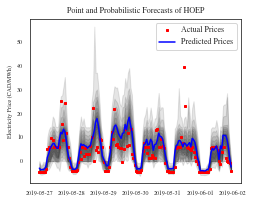

In [ ]:

plt.figure(figsize=(3.5,2.8))
plt.rcParams['font.family']='STIXGeneral'
plt.rcParams['font.size']=6
plt.rcParams['figure.autolayout']=True
plt.rcParams['axes.titlesize']=8
plt.rcParams['axes.labelsize']=6
plt.rcParams['lines.linewidth']=1
plt.rcParams['lines.markersize']=2
plt.rcParams['legend.fontsize']=8
plt.rcParams['mathtext.fontset']='stix'
plt.rcParams['mathtext.fontset']='custom'
plt.rcParams['legend.numpoints']=1
p='2019-05-27'
q='2019-06-01'
a=0.1
q1=GB[p:q]['q=0.05']
q2=GB[p:q]['q=0.95']
plt.fill_between(q1.index,q1,q2,color='black',alpha=a)

q3=GB[p:q]['q=0.1']
q4=GB[p:q]['q=0.9']
plt.fill_between(q1.index,q3,q4,color='black',alpha=a)

q3=GB[p:q]['q=0.15']
q4=GB[p:q]['q=0.85']
plt.fill_between(q1.index,q3,q4,color='black',alpha=a)

q3=GB[p:q]['q=0.2']
q4=GB[p:q]['q=0.8']
plt.fill_between(q1.index,q3,q4,color='black',alpha=a)

q3=GB[p:q]['q=0.25']
q4=GB[p:q]['q=0.75']
plt.fill_between(q1.index,q3,q4,color='black',alpha=a)

q3=GB[p:q]['q=0.3']
q4=GB[p:q]['q=0.7']
plt.fill_between(q1.index,q3,q4,color='black',alpha=a)

q3=GB[p:q]['q=0.35']
q4=GB[p:q]['q=0.65']
plt.fill_between(q1.index,q3,q4,color='black',alpha=a)

q3=GB[p:q]['q=0.4']
q4=GB[p:q]['q=0.6']
plt.fill_between(q1.index,q3,q4,color='black',alpha=a)

q3=GB[p:q]['q=0.45']
q4=GB[p:q]['q=0.55']
plt.fill_between(q1.index,q3,q4,color='black',alpha=a)

plt.plot(GB[p:q]['label'],'rs',lw=1,markersize=2,label='Actual Prices')
plt.plot(DF[p:q]['XGB'],color='blue',lw=1.5,label='Predicted Prices')
plt.legend()
plt.ylabel('Electricity Price (CAD/MWh)')
plt.title('Point and Probabilistic Forecasts of HOEP')
plt.savefig('FinalPic.pdf',dpi=300)
files.download('FinalPic.pdf')

In [ ]:
GB['HOEP']=test_labels.reshape(-1,1)
GB.head()

,label,q=0.05,q=0.1,q=0.15,q=0.2,q=0.25,q=0.3,q=0.35,q=0.4,q=0.45,q=0.5,q=0.55,q=0.6,q=0.65,q=0.7,q=0.75,q=0.8,q=0.85,q=0.9,q=0.95,I=90,I=80,I=70,I=60,I=50,I=40,I=30,I=20,I=10,CRPS,HOEP
2019-01-01 00:00:00,0.00,-3.470430,-2.997247,-1.844386,-0.829184,-0.236499,0.005226,0.006488,0.009121,0.011794,0.117657,0.588252,1.305168,2.683097,3.465385,5.366748,5.867281,7.385476,9.914421,13.094358,16.564788,12.911667,9.229861,6.696465,5.603247,3.460159,2.676609,1.296047,0.576458,216.987164,0.00
2019-01-01 01:00:00,0.00,-3.470430,-2.997247,-1.844386,-0.829184,-0.236499,0.005226,0.006488,0.009121,0.011794,0.020166,0.209228,1.010675,2.347212,3.465385,4.758637,5.867281,7.385476,9.914421,13.094358,16.564788,12.911667,9.229861,6.696465,4.995136,3.460159,2.340724,1.001555,0.197434,212.564831,0.00
2019-01-01 02:00:00,-0.11,-3.489399,-2.997247,-1.844386,-0.856761,-0.260365,0.004776,0.006488,0.009121,0.011794,0.013406,0.017740,0.240011,1.283132,2.144162,3.035977,5.209228,6.427327,7.857094,12.025231,15.514630,10.854341,8.271713,6.065989,3.296342,2.139386,1.276644,0.230891,0.005946,161.121598,-0.11
2019-01-01 03:00:00,-1.84,-3.470430,-2.997247,-1.844386,-0.829184,-0.236499,0.005226,0.006488,0.009121,0.011794,0.020166,0.242322,1.010675,2.347212,3.465385,4.758637,5.867281,7.385476,9.914421,13.133160,16.603589,12.911667,9.229861,6.696465,4.995136,3.460159,2.340724,1.001555,0.230529,316.635634,-1.84
2019-01-01 04:00:00,-0.47,-3.489399,-2.997247,-1.844386,-0.856761,-0.260365,0.004776,0.006488,0.009121,0.011794,0.013406,0.024049,0.251076,1.283132,2.243162,3.600605,5.209228,6.427327,7.857094,12.082005,15.571404,10.854341,8.271713,6.065989,3.860969,2.238386,1.276644,0.241956,0.012256,176.611344,-0.47


0.1
0.3
0.5
0.7
0.9
                     quantile_loss
method                            
Gradient Boosting         2.793578
Neural Network            2.808626
Quantile Regression       2.829791


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

method  Gradient Boosting  Neural Network  Quantile Regression
q                                                             
0.1              1.270637        1.242791             1.261379
0.3              2.798806        2.797985             2.794807
0.5              3.592012        3.632846             3.606249
0.7              3.649492        3.700516             3.723958
0.9              2.656942        2.668990             2.762564


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

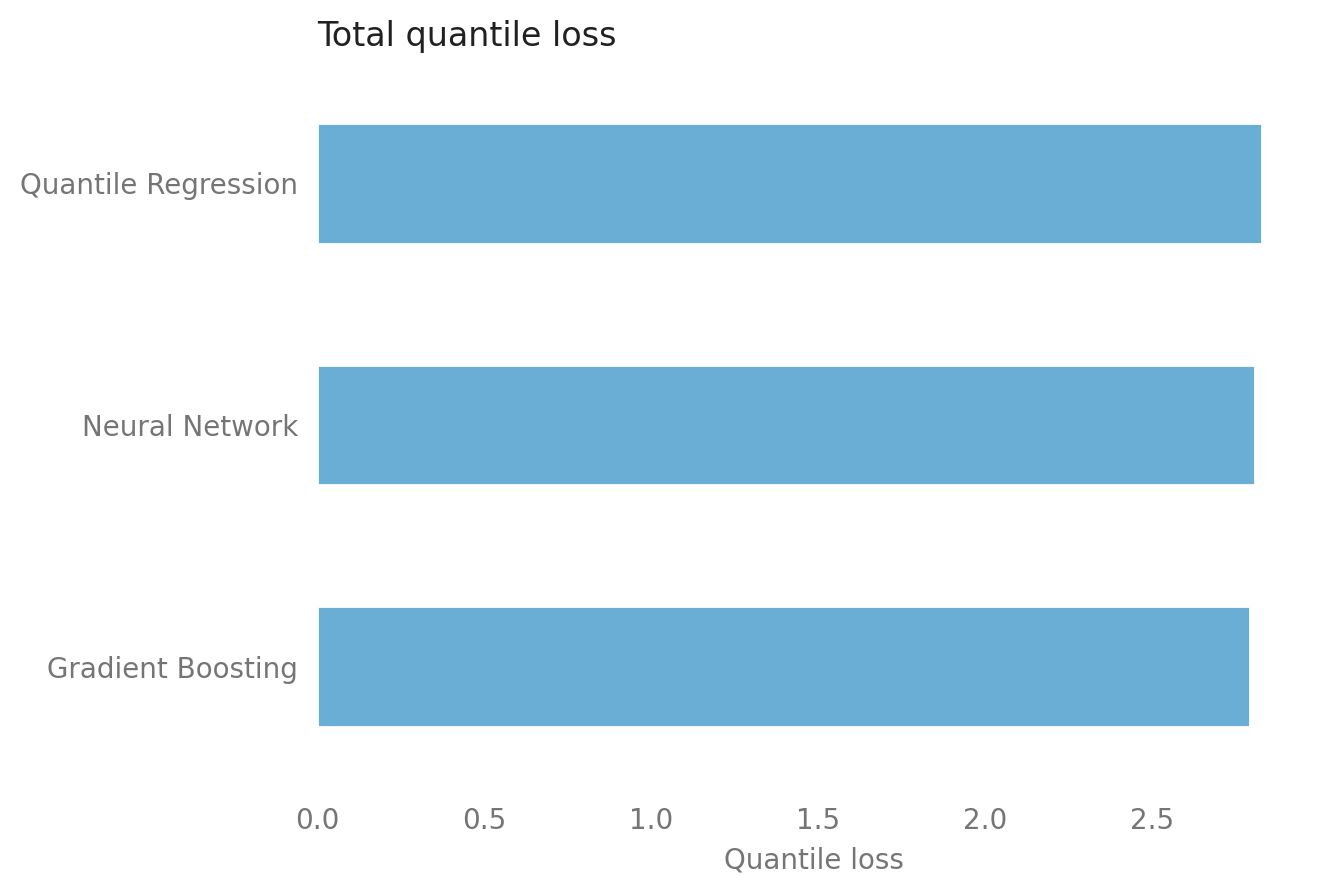

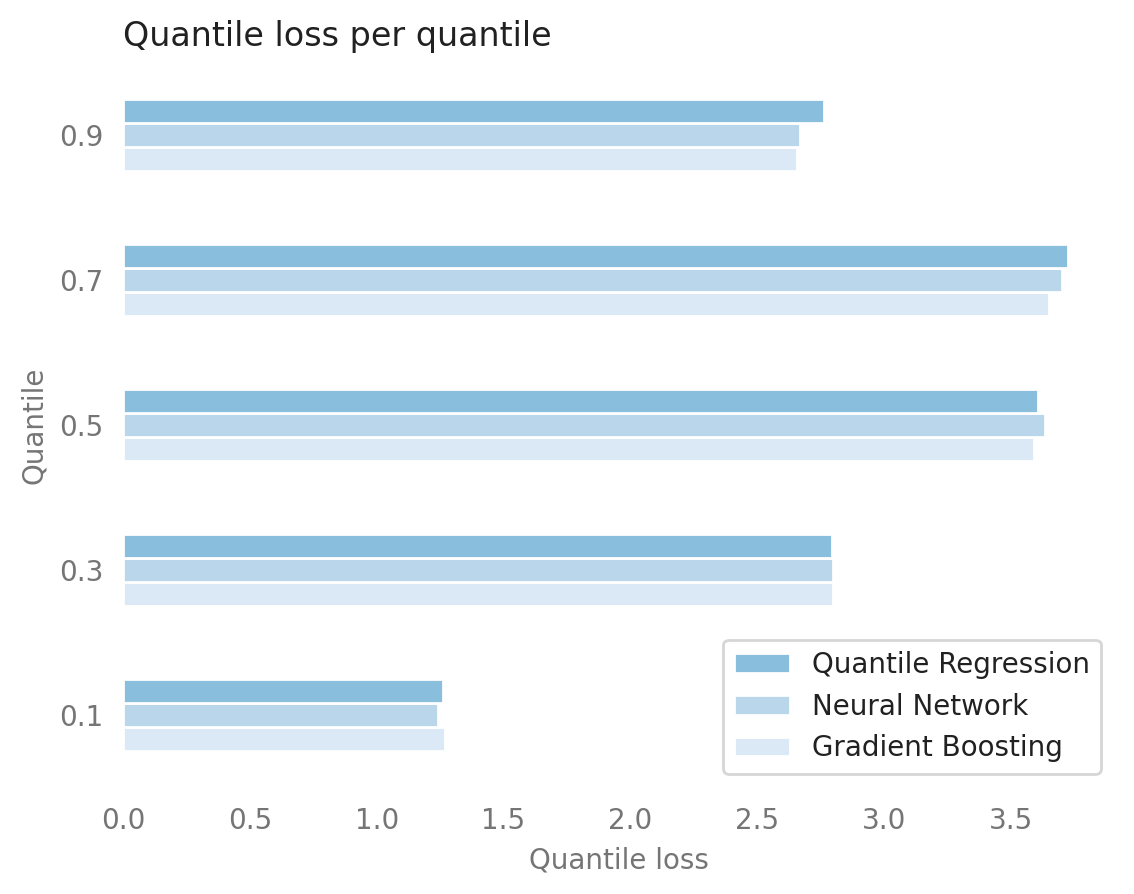

In [ ]:
#All features
#Same analysis but using all x features.
preds_full = preds[['method', 'q', 'label']].copy(deep=True)
x_train_full = train_df.copy(deep=True)
x_test_full = test_df.copy(deep=True)
#Reformat data for statsmodels.
X_train_full = sm.add_constant(x_train_full)
X_test_full = sm.add_constant(x_test_full)

#Quantreg
# Don't fit yet, since we'll fit once per quantile.
quantreg_full = sm.QuantReg(train_labels, X_train_full)
preds_full.loc[preds_full.method == 'Quantile Regression', 'pred'] = np.concatenate(
    [quantreg_full.fit(q=q).predict(X_test_full) for q in QUANTILES])

#GradientBoosting
preds_full.loc[preds_full.method == 'Gradient Boosting', 'pred'] = \
    np.concatenate([gb_quantile(X_train_full, train_labels, X_test_full, q) 
                    for q in QUANTILES]) 
#Neural Networks
preds_full.loc[preds_full.method == 'Neural Network', 'pred'] = np.concatenate(
    [keras_pred(x_train_full, train_labels, x_test_full, q) for q in QUANTILES]) 
#Compare
preds_full['quantile_loss'] = quantile_loss(preds_full.q, preds_full.label, preds_full.pred)
plot_loss_comparison(preds_full)